#### Check libs

In [1]:
import openvino
import cv2
cv2.__version__

'4.4.0-openvino'

#### Accessable videos

In [2]:
!ls *.avi

terrace1-c0.avi  terrace1-c1.avi  terrace1-c2.avi


#### Please, set video for testing

In [3]:
TEST_VIDEO = 'terrace1-c0.avi'

#### Play testing video

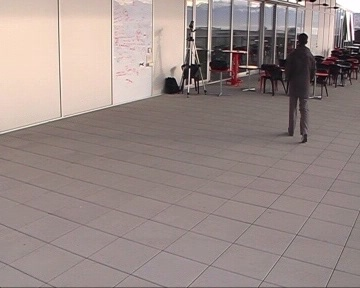

In [4]:
from IPython.display import clear_output, Image, display, HTML
import cv2

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(None, display_id=True)

try:
    ret = True
    while ret:
        ret, frame = video.read()
        if ret:
            display_handle.update(Image(data=cv2.imencode('.jpeg', frame)[1]))
except KeyboardInterrupt:
    video.release()

### Use SSD_MobileNetv2

#### Print all available models from OpenVINO model zoo

In [ ]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py --print_all

#### Download ready-to-use TF model

In [ ]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py \
--name ssd_mobilenet_v2_coco \
--output_dir ./data 

#### Develop wrapper for TF inference

In [8]:
import tensorflow as tf
import numpy as np

from typing import Tuple, Dict, List, AnyStr
import time
import os

IMG_WIDTH = 300
MODEL_INPUT_LAYER = 'image_tensor'
MODEL_OUTPUT_LAYER = ['num_detections', 'detection_classes', 'detection_scores', 'detection_boxes']

def tf_inference(graph: tf.Graph, 
                 image: np.array, 
                 input_name: AnyStr, 
                 outputs_names: List[AnyStr]) -> Dict[AnyStr, np.array]:  
    # Get the input tensor by name
    input_tensor = graph.get_tensor_by_name('{}:0'.format(input_name))
    
    # Fill input data
    feed_dict = {
        input_tensor: [image, ] 
    }

    # Collect output tensors
    output_tensors = []
    
    for output_name in outputs_names:
        tensor = graph.get_tensor_by_name('{}:0'.format(output_name))
        output_tensors.append(tensor)
    
    # Run inference and get performance
    with graph.as_default():
        with tf.Session(graph=graph) as session:
            outputs = session.run(output_tensors, feed_dict=feed_dict)
    
    # Collect inference results
    res = dict(zip(outputs_names, outputs))
    
    return res, 

def run_tf_model_on_image(path_to_pb_model: str, 
                          raw_image: np.ndarray) -> Tuple[Dict[AnyStr, np.array], float, np.array]:
    # Size of the image is 300x300 pixels, 3 channels in the RGB format
    
    resized_image = cv2.resize(raw_image, (IMG_WIDTH, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
    
    reshaped_image = np.reshape(resized_image, (IMG_WIDTH, IMG_WIDTH, 3))
        
    graph = tf.Graph()
    
    graph_def = tf.GraphDef()

    with open(path_to_pb_model, "rb") as model_file:
        graph_def.ParseFromString(model_file.read())

    with graph.as_default():
        tf.import_graph_def(graph_def, name='')
    
    start_time = time.time()
    raw_results = tf_inference(graph, reshaped_image, MODEL_INPUT_LAYER, MODEL_OUTPUT_LAYER)
    finish_time = time.time()
    
    return raw_results[0], finish_time-start_time, resized_image

#### Infer frame on TF model

Average FPS: 0.3197421025460726 


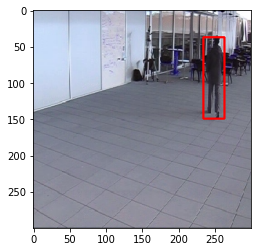

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

PROB_THRESH = .5
SSD_MOBILENET_TF_MODEL = os.path.join('.', 'data', 'public', 'ssd_mobilenet_v2_coco', 'ssd_mobilenet_v2_coco_2018_03_29', 'frozen_inference_graph.pb')

# Use frame from video playing (set stop for select frame)
tf_predictions, tf_average_inference_time, frame_for_output = run_tf_model_on_image(SSD_MOBILENET_TF_MODEL, frame)
print(f'Average FPS: {1 / tf_average_inference_time} ')

# Parsing of results
num_detections = tf_predictions['num_detections'][0]
classes = tf_predictions['detection_classes'][0]
scores = tf_predictions['detection_scores'][0]
boxes = tf_predictions['detection_boxes'][0]

# Filter detections by classes and scores
indexes = np.logical_and(scores>PROB_THRESH, classes==1) # 1 is a class for people
for box in boxes[indexes]:
    y1,x1,y2,x2 = np.int32(box*IMG_WIDTH) # Need convert to int for draw rectangle
    cv2.rectangle(frame_for_output, (x1,y1), (x2,y2), (255,0,0), 2)
    
plt.imshow(frame_for_output)

**Result**: normal accuracy of detection, but so slow

### Convert to OpenVINO model to speed up

In [10]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/model_optimizer/mo.py \
--output_dir=data/public/ssd_mobilenet_v2_coco/FP32 \
--reverse_input_channels \
--model_name=ssd_mobilenet_v2_coco \
--data_type=FP32 \
--transformations_config=${INTEL_OPENVINO_DIR}/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json \
--tensorflow_object_detection_api_pipeline_config=data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config \
--output=detection_classes,detection_scores,detection_boxes,num_detections \
--input_model=data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/vino/data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
	- Path for generated IR: 	/home/vino/data/public/ssd_mobilenet_v2_coco/FP32
	- IR output name: 	ssd_mobilenet_v2_coco
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	detection_classes,detection_scores,detection_boxes,num_detections
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	True
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with

#### Develop wrapper for OpenVINO inference

In [11]:
from openvino.inference_engine import IECore, IENetwork, ExecutableNetwork
import numpy as np
import cv2

from typing import Tuple, Dict, List, AnyStr
import time

def get_openvino_net(path_to_model_xml: str,
                     path_to_model_bin: str,
                     device='CPU', batch=1) -> Tuple[ExecutableNetwork, AnyStr, AnyStr]:
    ie = IECore()

    # First, create a network (Note: you need to provide model in the IR previously converted with Model Optimizer)
    net = ie.read_network(model=path_to_model_xml, weights=path_to_model_bin)

    # Get input and output blob of the network
    input_blob = next(iter(net.input_info))
    out_blob = next(iter(net.outputs))

    # Reshape the network to the needed batch
    n, c, h, w = net.inputs[input_blob].shape
    
    net.reshape({input_blob: (batch, c, h, w)})
    
    n, c, h, w = net.inputs[input_blob].shape
    exec_net = ie.load_network(network=net, device_name=device)
    del net
    return exec_net, input_blob, out_blob

def openvino_inference(exec_net: IENetwork,
                       image: np.ndarray,
                       input_blob: str, 
                       out_blob: str) -> Tuple[np.ndarray, float]:

    resized_image = image[..., ::-1]  # Read and preprocess the input image
    in_frame = resized_image.transpose((2, 0, 1))  # Change data layout from HWC to CHW

    # Now we run an inference on the target device
    inference_start = time.time()
    res = exec_net.infer(inputs={input_blob: [in_frame]})
    inference_end = time.time()

    return res[out_blob], inference_end - inference_start

def run_openvino_model_on_image(path_to_model_xml: str,
                                path_to_model_bin: str,
                                image: np.ndarray, 
                                net_img_shape: Tuple[int, int],
                                device: str = 'CPU', 
                                prints: str = True) -> Tuple[np.ndarray, float, np.array]:
    net, input_blob, output_blob = get_openvino_net(path_to_model_xml, path_to_model_bin)
    resized_image = cv2.resize(frame, net_img_shape, interpolation=cv2.INTER_NEAREST)
    predictions, inference_time = openvino_inference(net, resized_image, input_blob, output_blob)
        
    if prints:
        print(f'Inference Time of SSD MobileNet V2: {inference_time} seconds')
    fps = 1 / inference_time

    if prints:
        print(f'Frames per second (FPS): {fps}')
    
    return predictions, fps, resized_image

#### Infer frame on OpenVINO model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.


Inference Time of SSD MobileNet V2: 0.031580209732055664 seconds
Frames per second (FPS): 31.66540084706735


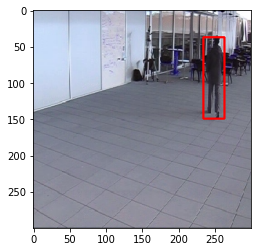

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

SSD_MOBILENET_OPENVINO_XML = os.path.join('.', 'data', 'public', 'ssd_mobilenet_v2_coco', 'FP32', 'ssd_mobilenet_v2_coco.xml')
SSD_MOBILENET_OPENVINO_BIN = os.path.join('.', 'data', 'public', 'ssd_mobilenet_v2_coco', 'FP32', 'ssd_mobilenet_v2_coco.bin')
PROB_THRESH = .5
IMG_WIDTH = 300
PEOPLE_CLASS_ID = 1

def draw_openvino_result_on_image(frame_for_output: np.array,
                                  preds: np.array,
                                  img_shape: Tuple[int, int]) -> np.array:
    for pred in preds: 
        # Need convert to int for draw rectangle
        x1,y1,x2,y2 = np.int32([pred[3]*img_shape[0], pred[4]*img_shape[1], pred[5]*img_shape[0], pred[6]*img_shape[1]]) 
        cv2.rectangle(frame_for_output, (x1,y1), (x2,y2), (255,0,0), 2)
    return frame_for_output

def filter_openvino_predictions(predictions: np.array,
                                prob_thresh: float,
                                class_index: int) -> np.array:
    preds = predictions[0][0]
    # Preds has structure [ret, class, probability, x1, ... , y2]
    indexes = np.logical_and(preds[:,2]>prob_thresh, preds[:,1]==1) # Filter detections by classes and scores
    return preds[indexes]
    
# Run the inference 
# Use frame from video playing (set stop for select frame)
predictions, fps, frame_for_output = run_openvino_model_on_image(SSD_MOBILENET_OPENVINO_XML, 
                                                                 SSD_MOBILENET_OPENVINO_BIN, 
                                                                 frame, (IMG_WIDTH, IMG_WIDTH))

preds = filter_openvino_predictions(predictions, PROB_THRESH, PEOPLE_CLASS_ID)
frame_for_output = draw_openvino_result_on_image(frame_for_output, preds, (IMG_WIDTH, IMG_WIDTH))

plt.imshow(frame_for_output)

**Result**: good accuracy and good speed

### Run OpenVINO model on video

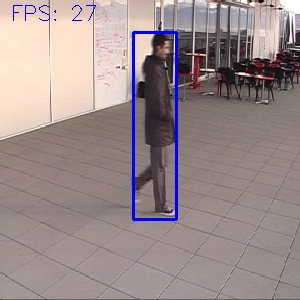

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.


In [13]:
from IPython.display import clear_output, Image, display, HTML
import cv2

PROB_THRESH = .5
IMG_WIDTH = 300
PEOPLE_CLASS_ID = 1

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(HTML(''), display_id=True)

det_net, input_blob, output_blob = get_openvino_net(SSD_MOBILENET_OPENVINO_XML, SSD_MOBILENET_OPENVINO_BIN)

try:
    ret = True
    while ret:
        ret, frame = video.read()
        
        if ret:
            resized_image = cv2.resize(frame, (IMG_WIDTH, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
            predictions, inference_time = openvino_inference(det_net, resized_image, input_blob, output_blob)
            
            preds = filter_openvino_predictions(predictions, PROB_THRESH, PEOPLE_CLASS_ID)
            
            frame_for_output = draw_openvino_result_on_image(resized_image, preds, (IMG_WIDTH, IMG_WIDTH))
            cv2.putText(frame_for_output,  f'FPS: {int(1/inference_time)}', (10,20), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)
            display_handle.update(Image(data=cv2.imencode('.jpeg', frame_for_output)[1]))
except KeyboardInterrupt as e:
    video.release()

**Result**: good accuracy and good speed

### Try to use SORT tracker

In [ ]:
# Install requirements
!pip3 install -r sort_requirements.txt

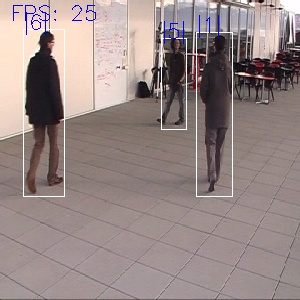

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.


In [15]:
from IPython.display import clear_output, Image, display, HTML
from sort import Sort
import cv2

SORT_MAX_AGE = 17
SORT_MIN_HITS = 2
SORT_IOU_THRESH = .3
DET_PROB_THRESH = .4
IMG_WIDTH = 300
PEOPLE_CLASS_ID = 1

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(HTML(''), display_id=True)

det_net, input_blob, output_blob = get_openvino_net(SSD_MOBILENET_OPENVINO_XML, 
                                                    SSD_MOBILENET_OPENVINO_BIN)
tracker = Sort(max_age=SORT_MAX_AGE, 
               min_hits=SORT_MIN_HITS,
               iou_threshold=SORT_IOU_THRESH)

try:
    ret = True
    while ret:
        ret, frame = video.read()

        if ret:
            inference_start = time.time()
            resized_image = cv2.resize(frame, (IMG_WIDTH, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)

            predictions, inference_time = openvino_inference(det_net, resized_image, input_blob, output_blob)
            
            preds = filter_openvino_predictions(predictions, DET_PROB_THRESH, PEOPLE_CLASS_ID)

            if len(preds)>0:
                # Convert detections to tracker's input format
                detections_for_trackers = np.array([np.append(pred[3:7],[pred[2]]) for pred in preds]) 

                tracked_bboxes = tracker.update(detections_for_trackers)

                # Draw results with track ids
                for t in tracked_bboxes:
                    x1,y1,x2,y2 = np.int32(t[:4]*IMG_WIDTH)
                    track_id = int(t[4])
                    cv2.rectangle(resized_image, (x1,y1), (x2,y2), (255,255,255), 1)
                    cv2.putText(resized_image,  f'|{track_id}|', (x1,y1), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)

            inference_end = time.time()
            cv2.putText(resized_image,  f'FPS: {int(1/(inference_end-inference_start))}', (10,20), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)

            display_handle.update(Image(data=cv2.imencode('.jpeg', resized_image)[1]))
except KeyboardInterrupt as e:
        video.release()

**Result**: good detection quality, but tracks jump between detections

### Try to use Dlib tracker

In [ ]:
# Install requirements
!pip3 install dlib

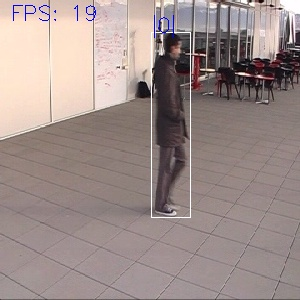

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.


In [17]:
from IPython.display import clear_output, Image, display, HTML
import cv2

from dlib_tracker import CorrelationTracker

DET_PROB_THRESH = .4
IMG_WIDTH = 300
PEOPLE_CLASS_ID = 1
IOU_THRESH = .4
TRACKER_MAX_AGE = 10

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(HTML(''), display_id=True)

det_net, input_blob, output_blob = get_openvino_net(SSD_MOBILENET_OPENVINO_XML, 
                                                    SSD_MOBILENET_OPENVINO_BIN)
trackers = []

def iou_batch(bb_test, bb_gt):
    """
        Computes IOU between two bboxes in the form [x1,y1,x2,y2]
    """
    bb_gt = np.expand_dims(bb_gt, 0)
    bb_test = np.expand_dims(bb_test, 0)
    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
    yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
    xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
    yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])
              + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)
    return o

try:
    ret = True
    while ret:
        ret, frame = video.read()

        if ret:
            inference_start = time.time()
            resized_image = cv2.resize(frame, (IMG_WIDTH, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)

            predictions, inference_time = openvino_inference(det_net, resized_image, input_blob, output_blob)
            
            preds = filter_openvino_predictions(predictions, DET_PROB_THRESH, PEOPLE_CLASS_ID)

            # Match trackers and detections
            detections_ids = np.ones(len(preds), dtype=np.uint8)
            for tracker in trackers:
                if tracker.is_active:
                    tracker_bbox = np.array(tracker.predict(frame))
                    for i, pred in enumerate(preds):
                        pred_bbox = pred[3:7]*IMG_WIDTH
                        if detections_ids[i]==1 and iou_batch(tracker_bbox,  pred_bbox)>IOU_THRESH:
                            tracker.update(pred_bbox, frame)
                            detections_ids[i]=0
                            break
                
            # Fix unused tracker    
            for tracker in trackers:
                if tracker.time_since_update > TRACKER_MAX_AGE:
                    tracker.is_active = False

            # For every new detection create new tracker
            untracked_detections = preds[detections_ids==1]
            for det in untracked_detections:
                tracker = CorrelationTracker(det[3:7]*IMG_WIDTH, frame)
                trackers.append(tracker)
                    
            # Draw results
            for tracker in trackers:
                if tracker.is_active:
                    x1,y1,x2,y2 = map(int, np.array(tracker.get_state()))
                    cv2.rectangle(resized_image, (x1,y1), (x2,y2), (255,255,255), 1)
                    cv2.putText(resized_image,  f'|{tracker.id}|', (x1,y1), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)

            
            inference_end = time.time()
            cv2.putText(resized_image,  f'FPS: {int(1/(inference_end-inference_start))}', (10,20), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)
            display_handle.update(Image(data=cv2.imencode('.jpeg', resized_image)[1]))
except KeyboardInterrupt as e:
    video.release()

**Result**: good detection quality, but tracks jump between detections

### Try to use OpenVINO detector and Reidentification models

#### Test OpenVINO detector

In [ ]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py \
--name person-detection-retail-0013 \
--output_dir ./data 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.


Inference Time of SSD MobileNet V2: 0.022544384002685547 seconds
Frames per second (FPS): 44.35694494384399


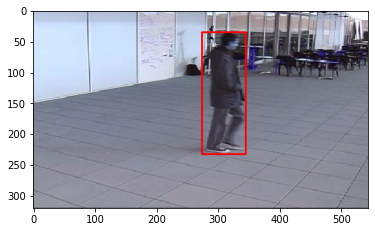

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt

import os

PEOPLE_OPENVINO_DETECTOR = os.path.join('.', 'data', 'intel', 'person-detection-retail-0013', 'FP32')
DEVICE = 'CPU'
IMG_SHAPE = (544, 320)

PEOPLE_DETECTOR_XML = os.path.join(PEOPLE_OPENVINO_DETECTOR, 'person-detection-retail-0013.xml')
PEOPLE_DETECTOR_BIN = os.path.join(PEOPLE_OPENVINO_DETECTOR, 'person-detection-retail-0013.bin')

predictions, fps, frame_for_output = run_openvino_model_on_image(PEOPLE_DETECTOR_XML, 
                                                                 PEOPLE_DETECTOR_BIN, 
                                                                 frame, IMG_SHAPE)

frame_for_output = draw_openvino_result_on_image(frame_for_output, preds, IMG_SHAPE)

plt.imshow(frame_for_output)

#### Test OpenVINO reidentificator

In [ ]:
!python3 ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py \
--name person-reidentification-retail-0270 \
--output_dir ./data 

In [ ]:
# Install requirements
!pip3 install munkres scipy

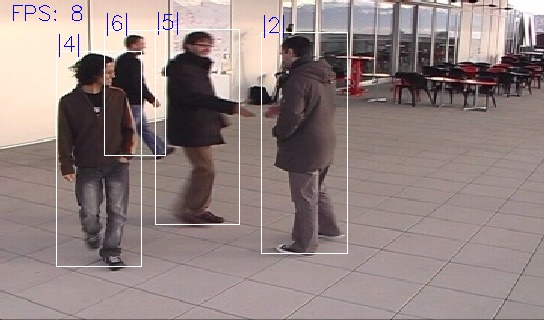

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.


In [35]:
from IPython.display import clear_output, Image, display, HTML
from munkres import Munkres
from scipy.spatial import distance
import numpy as np
import cv2

from typing import Tuple, AnyStr
import os

PEOPLE_OPENVINO_REID = os.path.join('.', 'data', 'intel', 'person-reidentification-retail-0270', 'FP32')
PEOPLE_REID_XML = os.path.join(PEOPLE_OPENVINO_REID, 'person-reidentification-retail-0270.xml')
PEOPLE_REID_BIN = os.path.join(PEOPLE_OPENVINO_REID, 'person-reidentification-retail-0270.bin')

DET_PROB_THRESH = .6
REID_INPUT_SHAPE = (128, 256)
COSINE_DIST_THRESH = .75
MAX_NON_DET_TRACK = 10
IMG_SHAPE = (544, 320)
TRACKER_MAX_AGE = 6

video = cv2.VideoCapture(TEST_VIDEO)
display_handle=display(HTML(''), display_id=True)

det_net, det_input_blob, det_output_blob = get_openvino_net(PEOPLE_DETECTOR_XML, PEOPLE_DETECTOR_BIN)
reid_net, reid_input_blob, reid_output_blob = get_openvino_net(PEOPLE_REID_XML, PEOPLE_REID_BIN)

class Detection:
    def __init__(self, bbox: Tuple[int,int,int,int], feature_vector: np.array, id=-1):
        self.bbox = bbox 
        self.feature = feature_vector
        self.id = id
        
class Tracker:
    count = 0
    
    def __init__(self, first_det: Detection):
        self.last_det = first_det
        Tracker.count += 1
        self.id = Tracker.count
        self.time_from_last_update = 0
        
    def update(self, new_det: Detection):
        new_det.id = self.id
        self.last_det = new_det
        self.time_from_last_update = 0
        

trackers = []
try:
    ret = True
    while ret:
        ret, frame = video.read()
        
        if ret:
            inference_start = time.time()
            resized_image = cv2.resize(frame, IMG_SHAPE, interpolation=cv2.INTER_NEAREST)
            predictions, inference_time = openvino_inference(det_net, resized_image, det_input_blob, det_output_blob)

            current_dets = []
            preds = predictions[0][0]
            for pred in preds[preds[:,2] > DET_PROB_THRESH]:
                x1,y1,x2,y2 = np.int32([pred[3]*IMG_SHAPE[0], pred[4]*IMG_SHAPE[1], 
                                        pred[5]*IMG_SHAPE[0], pred[6]*IMG_SHAPE[1]])

                if x1>0 and x2>0: # Several detections have x=-1
                    obj_img = resized_image[y1:y2,x1:x2]
                    obj_img = cv2.resize(obj_img, REID_INPUT_SHAPE)
                    reid_vector, inf_time = openvino_inference(reid_net, obj_img, reid_input_blob, reid_output_blob)
                    reid_vector = reid_vector.reshape((256)) 

                    det = Detection((x1,y1,x2,y2), reid_vector)
                    current_dets.append(det)
                

             # Increase time counter
            for tracker in trackers:
                tracker.time_from_last_update += 1
                
            if len(trackers) > 0 and len(current_dets) > 0:
                # Create cosine distance matrix and match objects in the frame and the DB
                hangarian = Munkres()
                dist_matrix = [
                                [distance.cosine(det.feature, tracker.last_det.feature) for tracker in trackers ] 
                                for det in current_dets 
                              ]
                combination = hangarian.compute(dist_matrix)        # Solve matching problem

                for idx_det, idx_tracker in combination:
                    if current_dets[idx_det].id==-1:             # This object has already been assigned an ID
                        dist = distance.cosine(current_dets[idx_det].feature, trackers[idx_tracker].last_det.feature)
                        if dist < COSINE_DIST_THRESH:
                            trackers[idx_tracker].update(current_dets[idx_det])
                    
            # Create new trackers
            for det in current_dets:
                if det.id == -1:
                    trackers.append(Tracker(det))
                        
            # Draw tracker data
            for tracker in trackers:
                if tracker.time_from_last_update < TRACKER_MAX_AGE:
                    x1,y1,x2,y2 = tracker.last_det.bbox
                    cv2.rectangle(resized_image, (x1,y1), (x2,y2), (255,255,255), 1)
                    cv2.putText(resized_image,  f'|{tracker.id}|', (x1,y1), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)

            inference_end = time.time()
            cv2.putText(resized_image,  f'FPS: {int(1/(inference_end-inference_start))}', (10,20), cv2.FONT_HERSHEY_SIMPLEX , .7, (255,0,0), 1)
            display_handle.update(Image(data=cv2.imencode('.jpeg', resized_image)[1]))
except KeyboardInterrupt:
    video.release()

**Result**: enough quality of detection, tracking, speed